In [19]:
# General imports
import pprint 
from typing import Union, List 
from tqdm.notebook import tqdm 
from collections import Counter

# Data Analysis and visualizations
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle
from matplotlib.ticker import FuncFormatter

# NLTK setup
import nltk 
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

# Text Processing 
import re 
import spacy
import gensim
from gensim import corpora
from emoji import demojize
from spacy.tokens import Doc
from nltk.corpus import stopwords
from gensim.models.callbacks import PerplexityMetric
from gensim.models.phrases import ENGLISH_CONNECTOR_WORDS
from gensim.models import LdaMulticore

# Dedicated NLP Visualizations 
import pyLDAvis
import pyLDAvis.gensim
from wordcloud import WordCloud

# Configurations 
nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('english'))

# Exclude common negation words from the stop words list
# negation_words = {'no', 'not', 'nor', 'neither', 'never', "n't", 'none', 'through'}
except_words = {'through'}
stop_words = stop_words - except_words

# Load Spacy model and disable irrelevant components for acceleration
nlp = spacy.load("en_core_web_md", disable=["parser", "ner"])
# nlp.max_length = 1500000  # Adjust based on your text size

# Set pprint options with indent 4
pprint = pprint.PrettyPrinter(indent=4).pprint

In [2]:
# verify working directory of the notebook 
import os 
print(os.getcwd())
import sys
path = os.path.abspath(os.path.join('../../')) # or the path to your source code
sys.path.insert(0, path)
print(path)

/home/jon/Documents/HEC/HEC/Session 4 Winter 2024/Text Mining/Project/NLP-FakeNews-Detection/Topic_Analysis
/home/jon/Documents/HEC/HEC/Session 4 Winter 2024/Text Mining/Project


In [3]:
#Load data 
#Path to Excel file
file_path = path + '/NLP-FakeNews-Detection/archive/truth_seeker.xlsx'

#Read Excel file
df = pd.read_excel(file_path)

#Remove NA from tweet
df = df.dropna(subset=['tweet'])

In [4]:
def clean_text(texts:Union[str, List[str], pd.Series], clean_emojis:bool=False) -> Union[str, List[str]]:

    # Create a list to store the cleaned texts
    cleaned_texts = []

    # Go through every text in the iput list of texts
    for doc in tqdm(nlp.pipe(texts, batch_size=50), 
                             total=len(texts), desc="Cleaning Texts"): 
        
        # print("Original text: ", doc)
        
        # Demojize the token.lemma for each token if it exists, else the token.text 
        tokens = [demojize(token.lemma_ if token.lemma_ != '-PRON-' else token.text).lower() for token in doc]

        # Convert emojis of form :emojiname: to words in format emojiEmojiName
        tokens = [re.sub(r':', '_', token) if token.startswith(':') and token.endswith(':') else token for token in tokens]

        # Remove emojis if prompted 
        if clean_emojis:
            tokens = [re.sub(r'_.*_', '', token) for token in tokens]

        # Remove non-alphabetic characters except for _ 
        tokens = [re.sub(r'[^a-z_]', '', token) for token in tokens]

        # Remove stopwordsm empty tokens and tokens with length less than 2
        tokens = [token for token in tokens if token not in stop_words and len(token) > 1]

        # # Join tokens that start with "no" or "not" to the next token, but preserve the original token too
        # tokens = [tokens[i] + '_' + tokens[i+1] if tokens[i] in negation_words else tokens[i] for i in range(len(tokens)-1)]
        
        # Append token to the cleaned_texts list
        cleaned_texts.append(tokens)

    # Form bigrams and trigrams models
    bigram = gensim.models.Phrases(cleaned_texts, min_count=1, threshold=1, connector_words=ENGLISH_CONNECTOR_WORDS)  # Create bigrams with a high threshold for fewer phrases
    trigram = gensim.models.Phrases(bigram[cleaned_texts], threshold=1, connector_words=ENGLISH_CONNECTOR_WORDS)  # Create trigrams based on the bigrams
    bigram_mod = gensim.models.phrases.Phraser(bigram)  # Convert bigram model into a more efficient Phraser object
    trigram_mod = gensim.models.phrases.Phraser(trigram)  # Convert trigram model into a Phraser object for efficiency

    # Form bigrams and trigrams
    cleaned_texts = [bigram_mod[doc] for doc in tqdm(cleaned_texts, desc="creating bigrams...")]
    cleaned_texts = [trigram_mod[bigram_mod[doc]] for doc in tqdm(cleaned_texts, desc="creating trigrams...")]

    return cleaned_texts

In [5]:
# Extract all the titles from the dataframe
texts = df['tweet'].tolist()

# Clean the corpus
clean_texts = clean_text(texts, clean_emojis=True)

Cleaning Texts:   0%|          | 0/134197 [00:00<?, ?it/s]

creating bigrams...:   0%|          | 0/134197 [00:00<?, ?it/s]

creating trigrams...:   0%|          | 0/134197 [00:00<?, ?it/s]

In [6]:
clean_texts

[['potus_biden',
  'blunders_month',
  'update_inflation',
  'delta_mismanagement',
  'covid',
  'kid_abandon',
  'americans_afghanistan',
  'arm_taliban',
  'border_crisis',
  'break_job',
  'growth_abuse',
  'power',
  'many_exec',
  'orders_through',
  'reconciliation_eviction',
  'moratorium_miss'],
 ['ssickrick',
  'stairmaster',
  'df',
  'many_people',
  'literally_starve',
  'street',
  'th_century',
  'capitalism',
  'grand',
  'meanwhile',
  'face_eviction',
  'moratorium_threaten',
  'make_million',
  'americans_homeless',
  'fuck',
  'corporatist',
  'propaganda'],
 ['supreme_court',
  'side_super',
  'rich',
  'property_owner',
  'poor',
  'struggle_american',
  'block_eviction',
  'moratorium',
  'pandemic',
  'even',
  'yet',
  'assholes',
  'get_ready',
  'homeless_people'],
 ['potus_biden',
  'blunders',
  'broken_campaign',
  'promise',
  'inflation_delta',
  'mismanagement_dems',
  'without',
  'leadership',
  'abandon_americans',
  'amp_armed',
  'taliban_border_cri

In [22]:
###############################################
### Step 1: Preparation and hyperparameters ###
###############################################

# Create a subset of randomly selected clean texts
clean_texts_subset = [clean_texts[i] for i in np.random.randint(0, len(clean_texts), max(50000, len(clean_texts)))]

# Create a dictionary mapping from word IDs to words
id2word = corpora.Dictionary(clean_texts_subset)

# Convert document into the bag-of-words (BoW) format = list of (token_id, token_count)
corpus = [id2word.doc2bow(text) for text in clean_texts_subset]

# Log the perplexity score at the end of each epoch.
perplexity_logger = PerplexityMetric(corpus=corpus, logger='shell')

# Create a dictionary with the parameters used in the LDA model 
lda_params = {
    'num_topics': 4,                 # The number of requested latent topics to be extracted from the training corpus
    'update_every': 1,               # Number of documents to be iteratively updated
    'chunksize': 50,                 # Number of documents to be used in each training chunk
    'passes': 15,                     # Number of passes through the corpus during training
    'alpha': 'symmetric',            # Hyperparameter affecting sparsity/thickness of the topics
    'iterations': 100,               # Maximum number of iterations through the corpus when inferring the topic distribution of a corpus
}

##############################
### Step 2: Model training ###
##############################

# Build LDA model with the corpus and dictionary
lda_model = LdaMulticore(
    corpus=corpus,
    num_topics=lda_params["num_topics"],
    id2word=id2word,
    chunksize=lda_params["chunksize"],
    workers=3,  # Adjust based on your machine's capability
    passes=lda_params["passes"],
    alpha=lda_params['alpha'],
    iterations=lda_params["iterations"]
)

############################
### Step 3: Model saving ###
############################

# Create a directory for the model if it doesn't exist
model_dir = 'models/lda_model'
os.makedirs(model_dir, exist_ok=True)

# Generate a custom name for the model based on the parameters
model_name = f'lda_model_{lda_params["num_topics"]}_{lda_params["update_every"]}_{lda_params["chunksize"]}_{lda_params["passes"]}_{lda_params["alpha"]}_{lda_params["iterations"]}.model'

# Save the model with the custom name
model_path = os.path.join(model_dir, model_name)
lda_model.save(model_path)

# Print the Keyword in the 4 topics
pprint(lda_model.print_topics())

[   (   0,
        '0.004*"one" + 0.004*"vaccine" + 0.004*"say" + 0.004*"get" + '
        '0.004*"know" + 0.003*"amp" + 0.003*"covid" + 0.003*"people" + '
        '0.003*"also" + 0.003*"biden"'),
    (   1,
        '0.006*"trump" + 0.005*"amp" + 0.004*"vote" + 0.004*"year" + '
        '0.003*"state" + 0.003*"time" + 0.003*"make" + 0.003*"people" + '
        '0.002*"pay" + 0.002*"us"'),
    (   2,
        '0.003*"amp" + 0.003*"obama" + 0.003*"say" + 0.003*"trump" + '
        '0.003*"year" + 0.003*"work" + 0.002*"reason" + 0.002*"mean" + '
        '0.002*"want" + 0.002*"job"'),
    (   3,
        '0.004*"say" + 0.003*"realdonaldtrump" + 0.003*"amp" + 0.003*"trump" + '
        '0.002*"vote" + 0.002*"know" + 0.002*"like" + 0.002*"get" + '
        '0.002*"wear_mask" + 0.002*"well"')]


In [23]:
model_name

'lda_model_4_1_50_15_symmetric_100.model'

In [24]:
lda_model = gensim.models.ldamodel.LdaModel.load(os.path.join(model_dir, model_name)) 

In [25]:
# Function to format topics and their contribution in each document
def format_topics_sentences(ldamodel=None, corpus=None, texts=None): 

    # Verify that parmeters are not None
    if ldamodel is None or corpus is None or texts is None:
        raise ValueError("The LDA model, corpus, and texts must be provided.")
    
    # verify that corpus and texts have the same length
    if len(corpus) != len(texts):
        raise ValueError("The corpus and texts must have the same length.")

    # Initialize a list to store each document's dominant topic and its properties
    records = []

    # Iterate over each document in the corpus
    for i, row_list in tqdm(enumerate(ldamodel[corpus]), desc="iterating through corpus...", total=len(corpus)):

        # Check if the model has per word topics or not to choose the correct element
        row = row_list[0] if ldamodel.per_word_topics else row_list

        # Sort each document's topics by the percentage contribution in descending order
        row = sorted(row, key=lambda x: (x[1]), reverse=True)

        # Extract the dominant topic and its percentage contribution for each document
        for j, (topic_num, prop_topic) in enumerate(row):

            # Only the top topic (dominant topic) is considered
            if j == 0:

                # Get the topic words and weights
                wp = ldamodel.show_topic(topic_num)

                # Join the topic words
                topic_keywords = ", ".join([word for word, prop in wp])

                # Create the records
                record = (int(topic_num), round(prop_topic, 4), topic_keywords)

                # Append the dominant topic and its properties to the list
                records.append(record)

                # Exit the loop after the dominant topic is found
                break

    # Create the DataFrame from the accumulated rows
    sent_topics_df = pd.DataFrame(records, columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'])

    # Add the original text of the documents to the DataFrame
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)

    # Reset the index of the DataFrame for aesthetics and readability
    sent_topics_df = sent_topics_df.reset_index()

    # Rename the columns of the DataFrame for clarity
    sent_topics_df.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

    return sent_topics_df



In [26]:
# Apply the function to the LDA model, corpus, and original texts to get the topic distribution DataFrame
df_dominant_topic = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=clean_texts_subset)

# Display the first 10 rows of the DataFrame
df_dominant_topic.head(10)

iterating through corpus...:   0%|          | 0/134197 [00:00<?, ?it/s]

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0,0.8818,"one, vaccine, say, get, know, amp, covid, people, also, biden","[charismamoon, try, pessimist, know, deal, desantis, trump, marco, annihilate, trump_lil, marco,..."
1,1,2,0.9569,"amp, obama, say, trump, year, work, reason, mean, want, job","[kayleighmcenany, ted_nugent_call_obama, subhuman_mongrel, chimpanzee, pos, suck_machine_gun, ca..."
2,2,3,0.5697,"say, realdonaldtrump, amp, trump, vote, know, like, get, wear_mask, well","[gance_linda, richard, dwagon, marilu, rbbellingham, beverlymccord, loudobbs, gopleader, foreign..."
3,3,0,0.6664,"one, vaccine, say, get, know, amp, covid, people, also, biden","[repdonbacon, except, violence_woman, police_funding, vote_twice, americans, rescue_plan, evicti..."
4,4,2,0.7738,"amp, obama, say, trump, year, work, reason, mean, want, job","[know, despite, small_population, size, swaziland_high_rate_hiv, aids_infection, world_country, ..."
5,5,0,0.9477,"one, vaccine, say, get, know, amp, covid, people, also, biden","[dailyedge, matt_gaetz_vote_anti, human_trafficking, bill_later, claim, adopt_young, boy_cuba, w..."
6,6,0,0.8925,"one, vaccine, say, get, know, amp, covid, people, also, biden","[tearoombetty, beau_biden_rolex, die_cancer, father_wear, son, memory]"
7,7,3,0.9478,"say, realdonaldtrump, amp, trump, vote, know, like, get, wear_mask, well","[charliesweeney, victoriousjv, stinkfist, annbauerwriter, realmeganhunter, science, huh, go, ign..."
8,8,2,0.9316,"amp, obama, say, trump, year, work, reason, mean, want, job","[soxysteelchic, potus_blame, trump, plan_action, need, single, player, healthcare, progressive_t..."
9,9,3,0.9158,"say, realdonaldtrump, amp, trump, vote, know, like, get, wear_mask, well","[vote, woman, violence_women_act, sinverguenza, rt, bettinainclan, bring, marco_rubio]"


In [27]:
# Increase the maximum width of columns in pandas DataFrame displays to show more characters
pd.options.display.max_colwidth = 100

# Initialize an empty DataFrame to store sorted topic information
sent_topics_sorteddf_mallet = pd.DataFrame()

# Group the DataFrame by the 'Dominant_Topic' column
sent_topics_outdf_grpd = df_dominant_topic.groupby('Dominant_Topic')

# Iterate over each group representing a single dominant topic
for i, grp in sent_topics_outdf_grpd:
    # Sort the grouped DataFrame by 'Perc_Contribution' in descending order and take the first row
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet,
                                             grp.sort_values(['Topic_Perc_Contrib'], ascending=False).head(1)],
                                            axis=0)

# Reset the index of the sorted DataFrame to be continuous and start from 0
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)
sent_topics_sorteddf_mallet = sent_topics_sorteddf_mallet.drop(columns=["Document_No"])

# Assign column names to the sorted DataFrame for better readability
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Display the first 10 rows of the sorted DataFrame to show the most representative text for each topic
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0,0.9830,"one, vaccine, say, get, know, amp, covid, people, also, biden","[canadapain_ptsdadvocate, headdock_heatherlinda, spicypurritos_terrime, pithypins_danniedean, ho..."
1,1,0.9850,"trump, amp, vote, year, state, time, make, people, pay, us","[q_estrada, whurensohn, kirschenmanreid, ianlstrain_markweccleston, openthread, dianeazarian, su..."
2,2,0.9857,"amp, obama, say, trump, year, work, reason, mean, want, job","[jptlowy, thefoxygoddess, mcfunny, drfyl, stahpl, provaxtexan, swedishchf, ksbyauntienic, margie..."
3,3,0.9817,"say, realdonaldtrump, amp, trump, vote, know, like, get, wear_mask, well","[aschild, paulkayallday, narvuntien, plhartungrn, johndublin_amcelha, keithamccluskey, kenneth, ..."


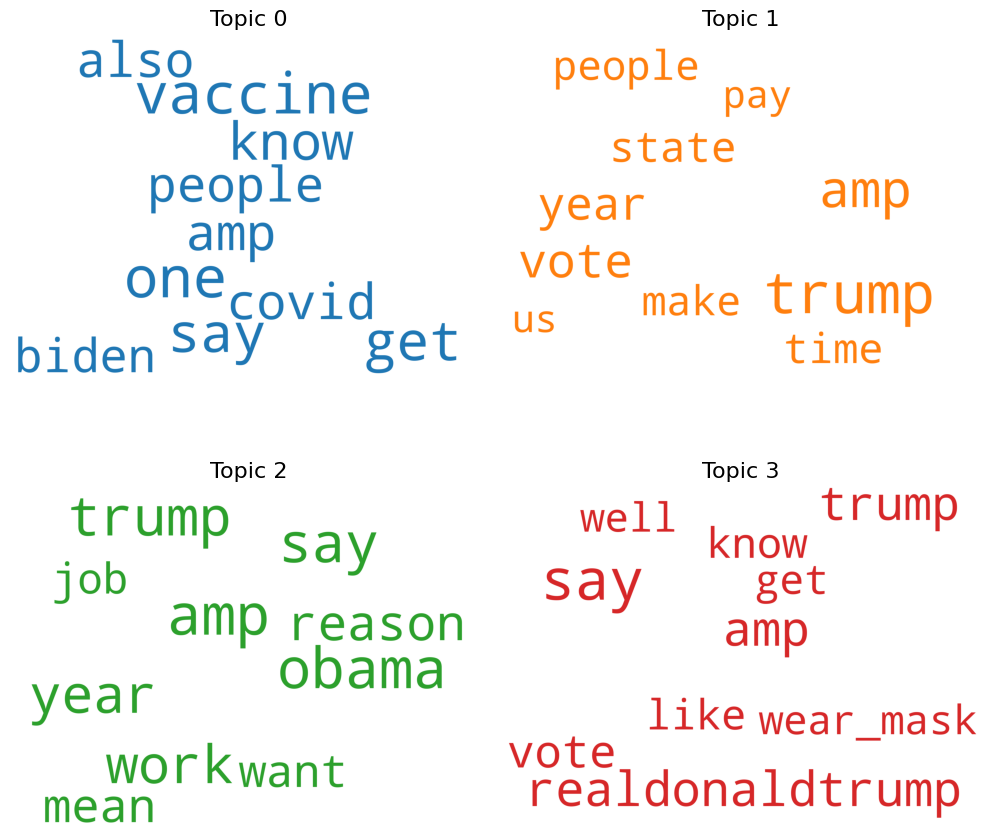

In [29]:
# Extracting a list of colors from the TABLEAU_COLORS dictionary
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

# Creating a WordCloud object with specified parameters
cloud = WordCloud(stopwords=stop_words,  # Providing stopwords for the WordCloud
                  background_color='white',  # Setting background color to white
                  width=2500,  # Setting width of the WordCloud
                  height=1800,  # Setting height of the WordCloud
                  max_words=30,  # Limiting maximum number of words in the WordCloud
                  colormap='tab10',  # Setting colormap for colors
                  color_func=lambda *args, **kwargs: cols[i],  # Setting custom color function for the WordCloud
                  prefer_horizontal=1.0)  # Setting horizontal preference for word orientation

# Extracting topics from lda_model and formatting them
topics = lda_model.show_topics(formatted=False)

# Creating a subplot grid for displaying multiple WordClouds
fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

# Iterating over each subplot and displaying WordCloud for each topic
for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])  # Extracting words for the current topic
    cloud.generate_from_frequencies(topic_words, max_font_size=300)  # Generating WordCloud from word frequencies
    plt.gca().imshow(cloud)  # Displaying WordCloud on current axis
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))  # Setting title for the WordCloud
    plt.gca().axis('off')  # Turning off axis for cleaner visualization

# Adjusting spacing between subplots and removing unnecessary axis
plt.subplots_adjust(wspace=0, hspace=0)  # Adjusting spacing between subplots
plt.axis('off')  # Turning off axis for the entire figure
plt.margins(x=0, y=0)  # Setting margins to zero for tighter layout
plt.tight_layout()  # Adjusting layout for better visualization
plt.show()  # Displaying the entire plot

In [20]:
def plot_topic_keywords(lda_model, clean_texts):

    # Extract topics and flatten data
    topics = lda_model.show_topics(formatted=False)
    data_flat = [w for w_list in clean_texts for w in w_list]
    counter = Counter(data_flat)

    # Initialize empty list to store data
    out = []

    # Iterate over topics and their words to retrieve the weights and
    for i, topic in topics:
        for word, weight in topic:
            out.append([word, i , weight, counter[word]])

    # Create DataFrame from collected data
    df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])

    # Plot Word Count and Weights of Topic Keywords
    fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)

    # Define colors for each subplot
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    # Iterate over subplots
    for i, ax in enumerate(axes.flatten()):
        # Plot bar chart for word count
        ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')

        # Create twinx axis for importance
        ax_twin = ax.twinx()

        # Plot bar chart for word importance
        ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')

        # Set y-axis labels
        ax.set_ylabel('Word Count', color=cols[i])
        ax_twin.set_ylim(0, 0.030)
        ax.set_ylim(0, 3500)

        # Set title for subplot
        ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)

        # Hide y-axis ticks
        ax.tick_params(axis='y', left=False)

        # Rotate x-axis labels
        ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')

        # Add legends
        ax.legend(loc='upper left')
        ax_twin.legend(loc='upper right')

    # Adjust layout
    fig.tight_layout(w_pad=2)
    fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)

    # Show plot
    plt.show()


/tmp/ipykernel_55788/3791853577.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/tmp/ipykernel_55788/3791853577.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/tmp/ipykernel_55788/3791853577.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/tmp/ipykernel_55788/3791853577.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df.loc[df.topic_id==i, 

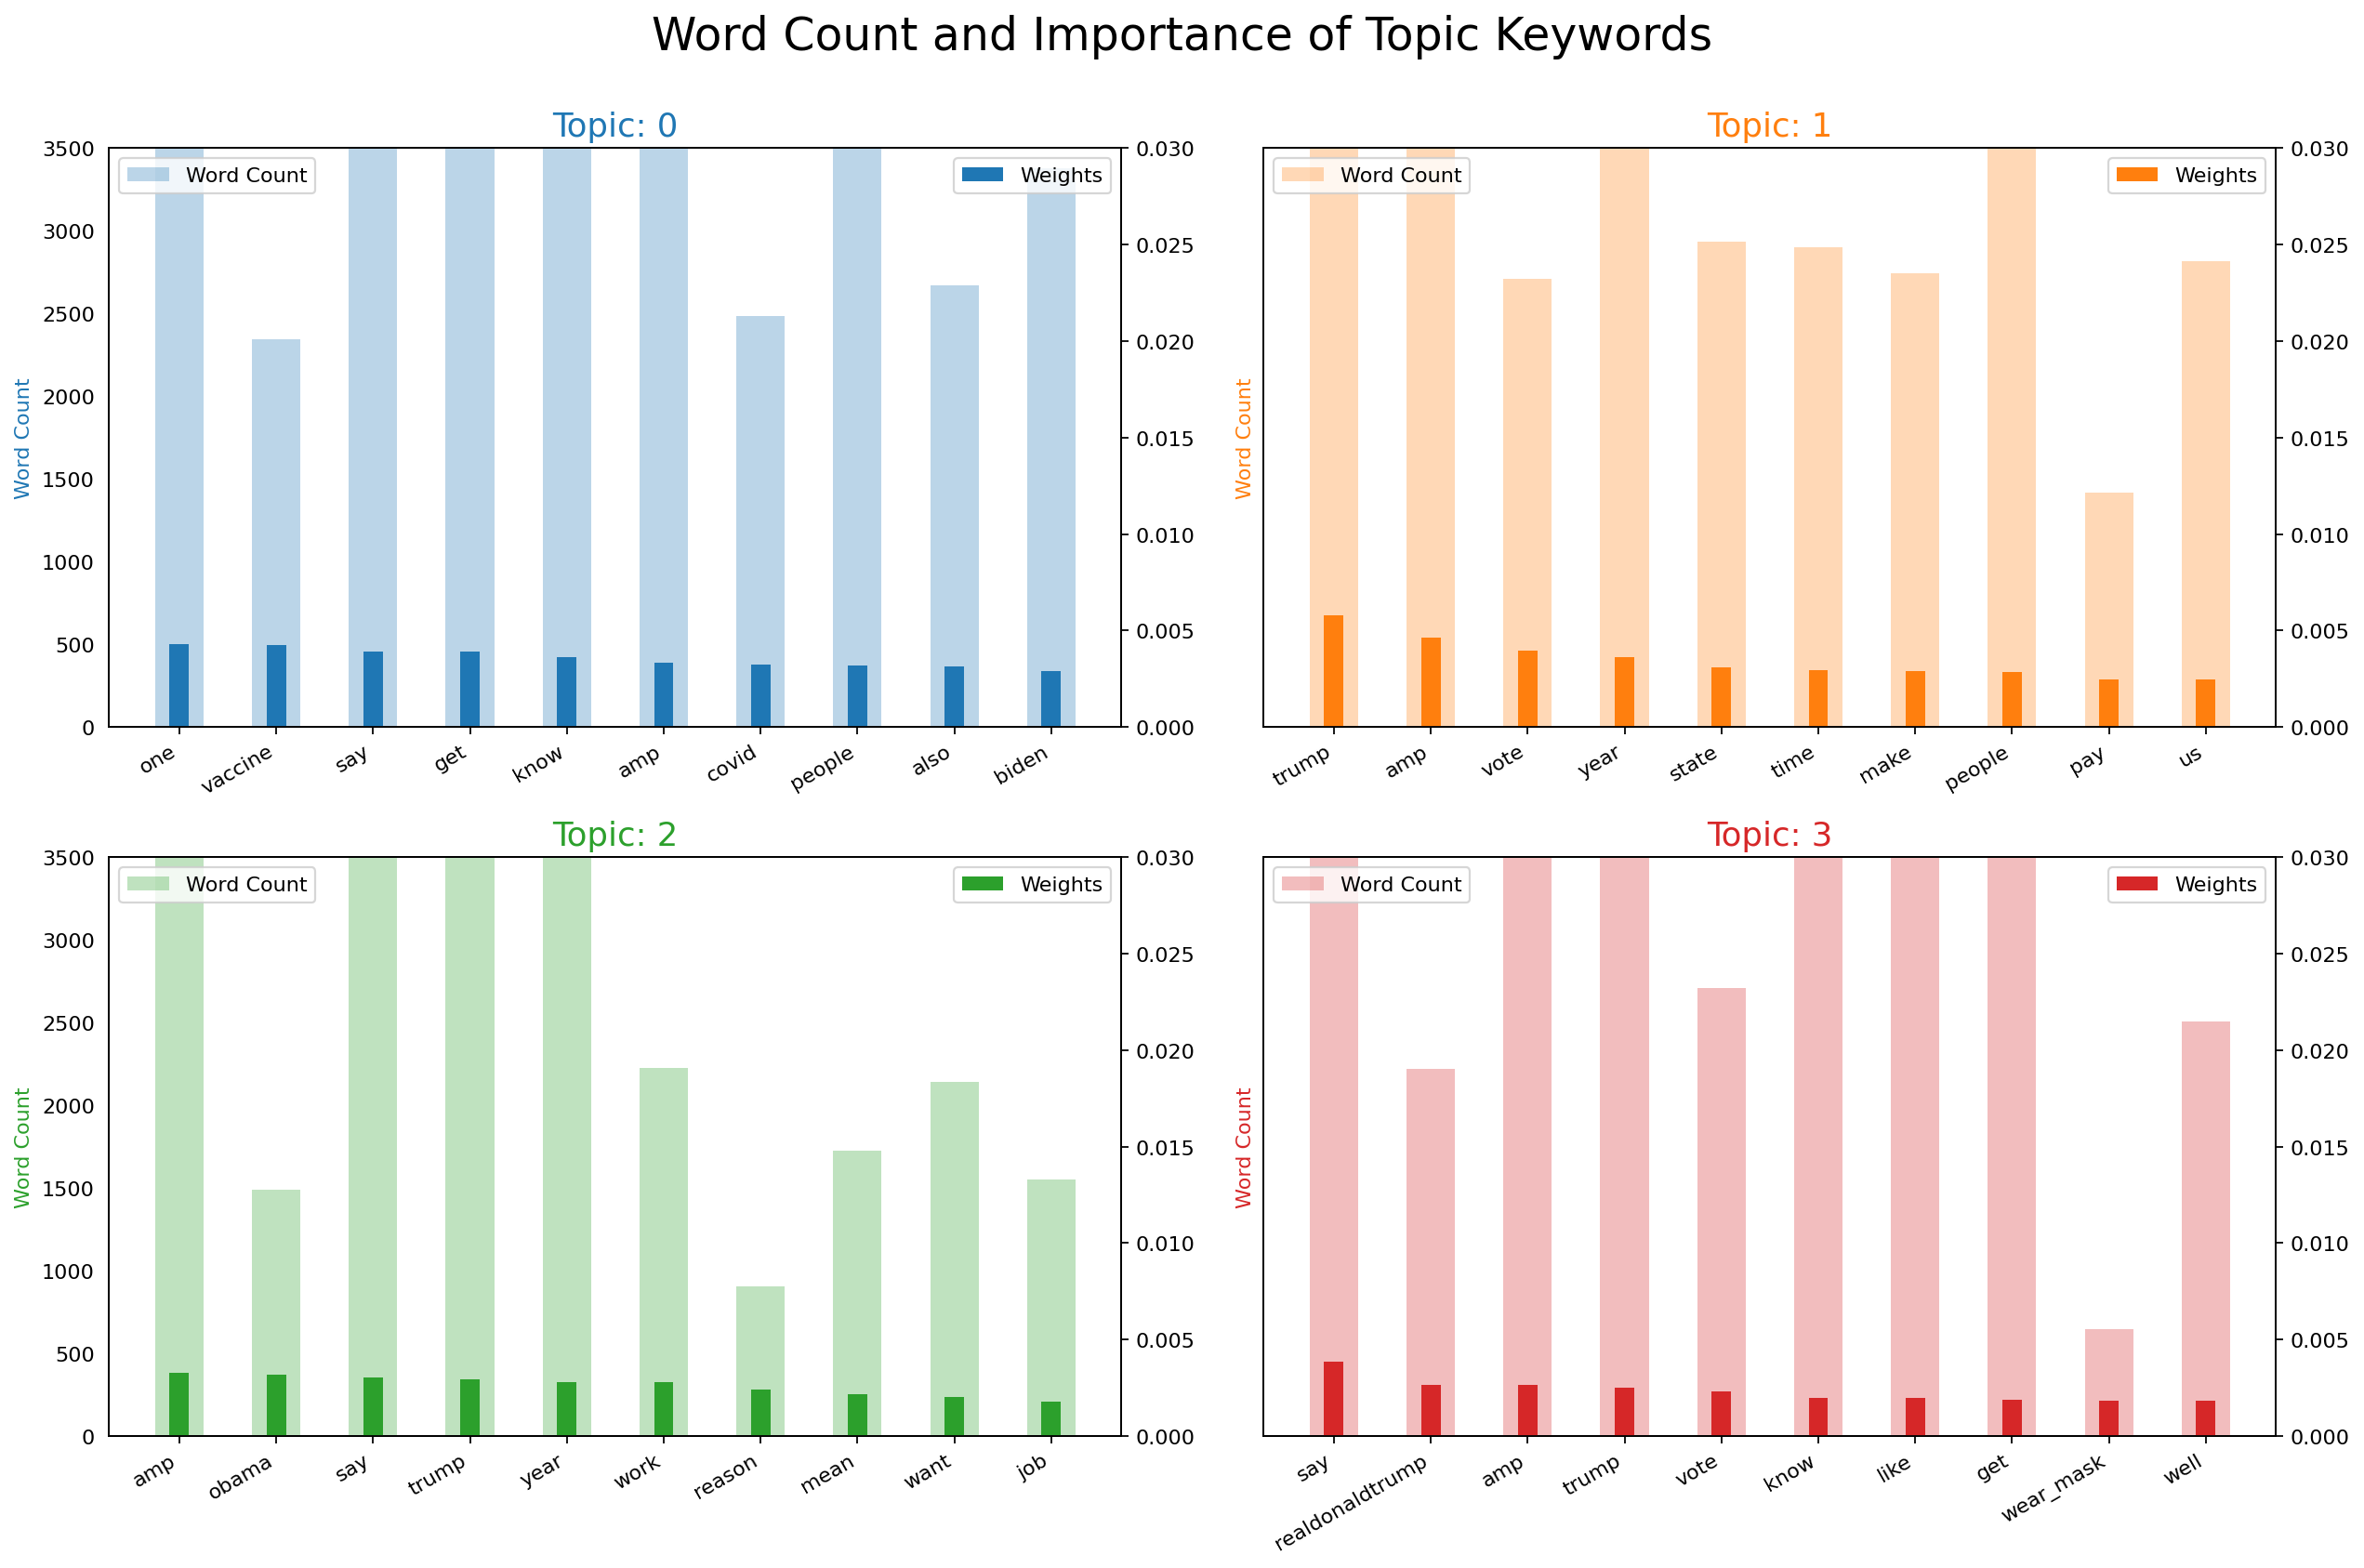

In [31]:
plot_topic_keywords(lda_model, clean_texts)

In [32]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

/home/jon/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/home/jon/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/home/jon/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/home/jon/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/home/jon/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.056796 -0.004657       1        1  32.473613
1      0.099209 -0.217441       2        1  26.034265
2      0.116911  0.211506       3        1  21.775741
3     -0.272916  0.010592       4        1  19.716381, topic_info=              Term         Freq        Total Category  logprob  loglift
244        vaccine  2425.000000  2425.000000  Default  30.0000  30.0000
128           vote  2622.000000  2622.000000  Default  29.0000  29.0000
513          obama  1423.000000  1423.000000  Default  28.0000  28.0000
701           work  2225.000000  2225.000000  Default  27.0000  27.0000
1863  minimum_wage  1095.000000  1095.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
1981         leave   415.834836   848.256943   Topic4  -6.7260   0.9108
397          since   456.483245  1887.440545   Topic4  -6.6327   0.2043
102           rate   404.267516  1066.268844   Topic4  -6.7542   0.6539
1155           one   450.002612  3866.606964   Topic4  -6.6470  -0.5272
501          right   412.201754  2628.025045   Topic4  -6.7348  -0.2288

[266 rows x 6 columns], token_table=      Topic      Freq              Term
term                                   
426       3  0.079952          abortion
426       4  0.918693          abortion
2465      1  0.998249    administration
3104      1  0.999052       afghanistan
2224      4  0.998004  african_american
...     ...       ...               ...
503       3  0.331285              year
503       4  0.078276              year
1389      1  0.142482          year_ago
1389      2  0.856425          year_ago
1688      2  0.997657          year_old

[329 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4])